In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utilities.OneHotEncoder import OneHotEncoder
from utilities.DataPreProcessor import DataPreProcessor

In [48]:
df_pdb_data_no_seq = pd.read_csv('resources/pdb_data_no_dups.csv')
df_pdb_seq = pd.read_csv('resources/pdb_data_seq.csv')
print("..Read data files..")

..Read data files..


In [49]:
# filtering out only protein structures
df_protein_seq = df_pdb_seq[(df_pdb_seq['macromoleculeType'] == 'Protein')]

In [50]:
# joining two data sets for protein Seq - classification

df_protein_final = df_protein_seq.merge(df_pdb_data_no_seq)

df_protein_seq_final = df_protein_final[['sequence', 'classification']]

df_protein_seq_final.head()

,sequence,classification
0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT
1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,HYDROLASE(O-GLYCOSYL)
2,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT
3,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,HYDROLASE(O-GLYCOSYL)
4,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT


In [51]:
# drop na values in the data frame

df_protein_seq_final = df_protein_seq_final.dropna()
print("filtered data with NA values")

filtered data with NA values


In [52]:
##One_hot encoding

one_hot_encoder = OneHotEncoder()

one_hot_encoder.find_unique_amino_acids(df_protein_seq_final['sequence'])
print("Unique Amino Acid Set...")

Unique Amino Acid Set...


In [53]:
## creates an encoded dictionaryfor each Amino Acid
one_hot_encoder.create_one_hot_dict()

data_pre_processor = DataPreProcessor(one_hot_encoder,
                                      None,
                                      df_protein_seq_final['classification']
                                      .value_counts().to_dict())

In [54]:
## delete least preferred sequences
data_pre_processor.del_least_preferred()

df_protein_seq_final_for_modeling = \
    df_protein_seq_final[df_protein_seq_final['classification']
        .isin(data_pre_processor.count_dict_keys_as_list())]

df_protein_seq_final_for_modeling = \
    df_protein_seq_final_for_modeling.reset_index(drop=True)
print("final Shape of the DataSet {}".format(df_protein_seq_final_for_modeling.shape))

final Shape of the DataSet (291355, 2)


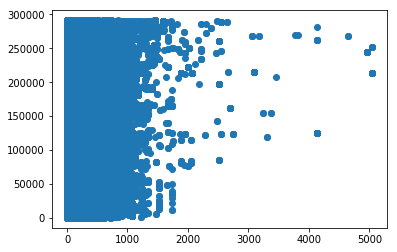

In [55]:
## plot sequence length
seq_lengths = list(map(lambda x: len(x),df_protein_seq_final_for_modeling['sequence']))

plt.scatter(seq_lengths,[i for i in range(len(seq_lengths))])
plt.show()


The above graph displays that, the density of all the sequences is approximately between 0-1500. I would only consider the sequence of length between 50-1200 which are reasonable to model.

In [42]:
## only considering sequences of length between 50 and 1200

df_protein_seq_final_for_modeling = \
    df_protein_seq_final_for_modeling[df_protein_seq_final_for_modeling.apply(
        lambda x: len(x['sequence']) <=1200 and len(x['sequence']) >=50 ,axis=1
    )]

In [43]:
print("final Shape of the DataSet {}".format(df_protein_seq_final_for_modeling.shape))

final Shape of the DataSet (271914, 2)


In [15]:
X_sequences = df_protein_seq_final_for_modeling['sequence']
y_label = df_protein_seq_final_for_modeling['classification']

In [20]:
## test process sequences

data_pre_processor.process_seqs_to_arrays(X_sequences[:1000], y_label[:1000],1200)
print("Getting Processed Seqs")
print(data_pre_processor.get_x().shape)
print("getting labels")
print(data_pre_processor.get_y().shape)
# print("getting protein categories")
# print(data_pre_processor.get_protein_categoeies())

Getting Processed Seqs
(1000, 1200, 25)
getting labels
(1000, 35)


### LSTM Modeling

In [21]:
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import SpatialDropout1D

In [38]:
embed_vol = 5000
embed_dim = 128
num_features = 25
max_seq_length = 1200

model = Sequential()
model.add(LSTM(200,input_shape=(max_seq_length, num_features),dropout=0.2, recurrent_dropout=0.2 ,return_sequences=True))
model.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(data_pre_processor.get_protein_categoeies()),activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1200, 200)         180800    
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               120400    
_________________________________________________________________
dense_4 (Dense)              (None, 35)                3535      
Total params: 304,735
Trainable params: 304,735
Non-trainable params: 0
_________________________________________________________________
None


## Modeling the first 1000 Sequences

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_pre_processor.get_x(), data_pre_processor.get_y(), test_size=0.20, random_state=42)

In [26]:
print("train data shape is {} and {}".format(X_train.shape,y_train.shape))
print("test data shape is {} and {}".format(X_test.shape,y_test.shape))

train data shape is (800, 1200, 25) and (800, 35)
test data shape is (200, 1200, 25) and (200, 35)


In [39]:
model.fit(X_train,y_train,epochs=1,verbose=2,batch_size=32)

Epoch 1/1
 - 416s - loss: 2.9757 - acc: 0.1988


In [40]:
score,acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = 16)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Score: 2.68
Validation Accuracy: 0.20
